In [2]:
%matplotlib inline
import pandas as pd

In [3]:
# 메타 데이터와 학습용 평점 정보 불러오기
metadata = pd.read_csv('./metadata.csv')
ratings = pd.read_csv('./ratings-train.csv')

In [4]:
# validation용 평점 정보 불러오기
# 데이터가 너무 크기 때문에 20%(frac = 0.2) 크기만 샘플링
# 학습하는 모두가 같은 샘플 데이터를 갖도록 random_state를 같은 값(17)으로 고정
ratings_valid = pd.read_csv('ratings-valid.csv').sample(random_state=17, frac=0.2)

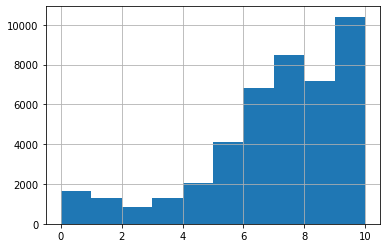

In [5]:
# 평점 정보의 분포 그려보기 (p. 20)
ratings['rating'].hist()

In [6]:
expected = ratings_valid[1:10]
answer = ratings_valid[:10]

In [19]:
metadata.head()

,itemid,title,genres,country,running_min
0,55396,시라노;연애조작단 (2010),로맨스/멜로/코미디,한국,121
1,42858,본 얼티메이텀 (2007),액션,미국,-1
2,121058,어느 가족 (2018),드라마,일본,121
3,4285,펀치 드렁크 러브 (2002),코미디,미국,95
4,36948,자토이치 (2003),액션/시대극,일본,115


In [20]:
ratings.head()

,userid,itemid,rating
0,MVdyRkY=,55396,9
1,TzZqVQ==,55396,7
2,REI4WTI=,55396,9
3,bDJ4aA==,55396,7
4,QktyMw==,55396,7


In [21]:
expected

,userid,itemid,rating
1000,NEpQdHA=,53983,6.000000
3543,OTQzaFo=,108037,NaN
4826,M2p2QTk=,87427,6.000000
4330,REhkazM=,95755,5.601971
3635,MWNiOE0=,70107,2.319746
1685,NzZtTHg=,111292,0.000000
5242,MkpYaGk=,125049,4.785714
2034,RjVKVw==,48632,6.773692
1910,REI4WTI=,47519,4.854972
1975,M0szalc=,108035,NaN


In [22]:
answer.head()

,userid,itemid,rating
1000,NEpQdHA=,53983,9
3543,OTQzaFo=,108037,8
4826,M2p2QTk=,87427,7
4330,REhkazM=,95755,3
3635,MWNiOE0=,70107,7


In [7]:
# RMSE (Root Mean Square Error) 계산하는 함수 만들기 (p. 23)

import numpy as np
def rmse(expected, answer):
    joined = pd.merge(answer, expected, on=['userid', 'itemid'], how='left')
    joined['rating_y'] = joined['rating_y'].fillna(0)
    joined['square_error'] = (joined['rating_x'] - joined['rating_y']) ** 2
    return np.sqrt(joined['square_error'].mean())

In [8]:
rmse(expected, answer)

2.8460498941515415

In [9]:
# 모든 예측을 8점으로 하는 추천 로직
def predict(u, i):
    return 8.0

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.7423239390279464

In [10]:
# 모든 예측을 전체 평점의 평균으로 계산하는 추천 로직 (p. 24)
r_mean = ratings['rating'].mean()
def predict(u, i):
    return r_mean

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.418031954051125

In [11]:
# 모든 예측을 주어진 사용자의 평균 평점으로 계산하는 추천 로직 (p. 25)
def predict(u, i):
    return ratings[ratings['userid'] == u]['rating'].mean()

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.1909154513519242

In [12]:
# 모든 예측을 주어진 영화의 평균 평점으로 계산하는 추천 로직 (p. 25)
def predict(u, i):
    return ratings[ratings['itemid'] == i]['rating'].mean()

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.237838086446809

In [13]:
# 서로 다른 사용자 u, v에 대해 jaccard similarity 계산하는 함수 (p. 28)
all_users = ratings['userid'].unique()
i_dict = {u: set(ratings[ratings['userid'] == u]['itemid']) for u in all_users}
def sim(u, v):
    # i_u = 소비자 u가 평점을 남긴 영화 집합
    # i_v = 소비자 v가 평점을 남긴 영화 집합
    i_u = i_dict[u]
    i_v = i_dict[v]
    
    cup = i_u | i_v
    if len(cup) == 0:
        return 0.0
    cap = i_u & i_v
    return len(cap) / len(cup)

In [14]:
sim('TERhUA==', 'Q1ladXM=')

0.08333333333333333

In [15]:
# 비슷한 영화를 소비한 k명의 사용자 집합 U_u를 계산하는 similar_users(u, k) 함수 (p. 29)
def similar_users(u, k):
    sims = sorted([(sim(u, v), v) for v in all_users if u != v], reverse=True)
    topk_users = [v for s, v in sims][:k]
    return pd.DataFrame(topk_users, columns=['userid'])

In [16]:
similar_users('TERhUA==', 5)

,userid
0,YzkyQQ==
1,NGdmcVQ=
2,M2hETGQ=
3,V0NyaQ==
4,QTB5d0E=


In [23]:
def predict(u, i):
    topk_users = similar_users(u, 5)
    topk_users['sim'] = topk_users.apply(lambda row: sim(u, row['userid']), axis=1)
    i_ratings = ratings[ratings['itemid'] == i]
    joined = pd.merge(topk_users, i_ratings, on='userid')
    joined['weighted_rating'] = joined['sim'] * joined['rating']
    return joined['weighted_rating'].sum() / joined['sim'].sum()

In [24]:
expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

c:\python37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


4.4360709881776135